In [1]:
import importlib

libraries = [
    "tensorflow",
    "numpy",
    "spektral",
    "matplotlib",
    "pandas",
    "sklearn"
]

for lib in libraries:
    try:
        if not importlib.util.find_spec(lib):
            raise ImportError("Package '%s' is not installed" % lib)
    except ImportError as e:
        print(e)

### Soil moisture data preprocessing

In [2]:
import numpy as np
import pandas as pd
import os

def load_italy():
    return np.load("Italy_data.npy"), np.load(os.path.join("labels", "Italy.npy"))

def load_calif():
    return np.load("California_data.npy"), np.load(os.path.join("labels", "California.npy"))

def load_southafrica():
    return np.load("SouthAfrica_data.npy"), np.load(os.path.join("labels", "SouthAfrica.npy"))

def load_data(area):
    regions = ["italy", "california", "southafrica"]
    if area not in regions:
        raise ValueError("'region' must be one of {} but was {}".format(regions, region))
    else:
        if area == "italy":
            return load_italy()
        if area == "california":
            return load_calif()
        if area == "southafrica":
            return load_southafrica()

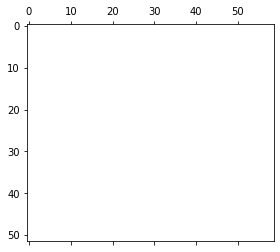

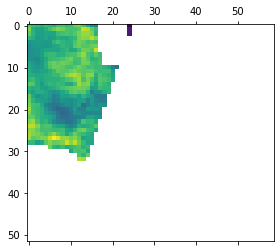

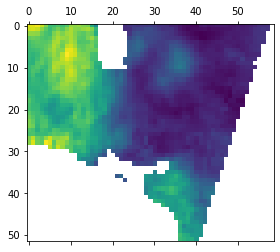

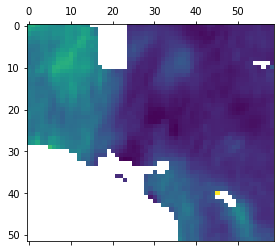

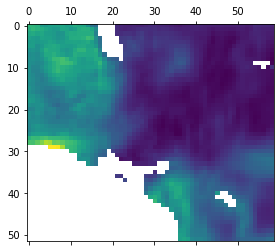

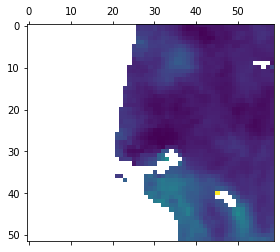

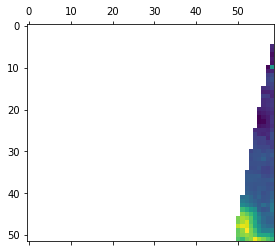

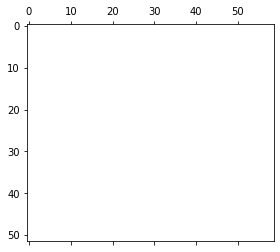

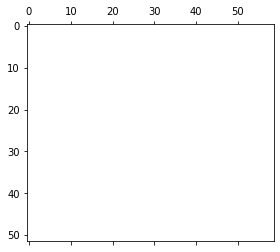

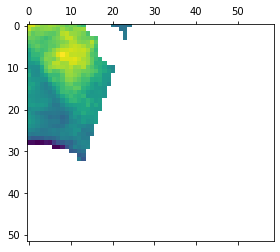

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

region = "california"
data, label_map = load_data(region)

for i in range(10):
    fig, ax = plt.subplots()
    ax.matshow(data[..., i * 10])
    plt.show()

In [4]:
print("Max: %s" % np.nanmax(data))
print("Min: %s" % np.nanmin(data))
print("Missing value ratio: %s" % (np.sum(np.isnan(data)) / np.prod(data.shape)))
print("Data shape: {}".format(data.shape))

Max: 0.5449867
Min: 0.02
Missing value ratio: 0.6348919037339432
Data shape: (52, 59, 732)


**Write a function which linearly interpolates to fill missing data**

We will use the `pandas` library to make a `Dataframe` that can easily be interpolated linearly to fill missing values.

We will assume that the array has nodes along the first dimension and time along the second (and last) dimension.

In [5]:
def lin_interp(data_values):
    """
    data: array (Last axis MUST be time!)
    """
    ndim = data_values.ndim
    in_shape = data_values.shape
    if ndim > 2:
        data_values = data_values.reshape(-1, data_values.shape[-1])
    return pd.DataFrame(data_values.T).interpolate(method="linear", limit_direction="forward").interpolate(method="linear",
                                                                                                    limit_direction="backward").values.T

To show this in operation, here is an example, before and after interpolation. Note that if there are no observed values over time the `nan` values aren't filled.

In [6]:
test_array = np.array([[1., np.nan, np.nan, 7.], [np.nan, 2., 3., np.nan], [np.nan, np.nan, np.nan, np.nan], [np.nan, 3., np.nan, 5]])

print("Before:")
print(test_array)
print()
print("After:")
print(lin_interp(test_array))

Before:
[[ 1. nan nan  7.]
 [nan  2.  3. nan]
 [nan nan nan nan]
 [nan  3. nan  5.]]

After:
[[ 1.  3.  5.  7.]
 [ 2.  2.  3.  3.]
 [nan nan nan nan]
 [ 3.  3.  4.  5.]]


**Write a function to normalize the data between 0 and 1 (if not already)**

Generally speaking, it is common practice to normalize features in the data before using deep learning methods. This ensures that gradients will be comparable across features and applications which means that there is less need to tune optimization parameters such as learning rates/momentum etc.

We will again assume that the function input will be a 2-dimensional array with #nodes x #timesteps.

In [7]:
def normalize(data_values):
    maximum = np.nanmax(data_values, axis=0, keepdims=True)
    minimum = np.nanmin(data_values, axis=0, keepdims=True)
    return (data_values - minimum) / (maximum - minimum)

In [8]:
test_array = np.array(np.array([[1,2,3],[4,1,1], [3., 1., 3.5]]))

print("Before:")
print(test_array)
print()
print("After:")
print(normalize(test_array))

Before:
[[1.  2.  3. ]
 [4.  1.  1. ]
 [3.  1.  3.5]]

After:
[[0.         1.         0.8       ]
 [1.         0.         0.        ]
 [0.66666667 0.         1.        ]]


**Use of functions to process data and save**

In [9]:
filled = lin_interp(data.reshape(-1, data.shape[-1]))
normalized = normalize(filled)

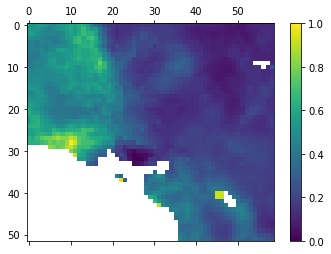

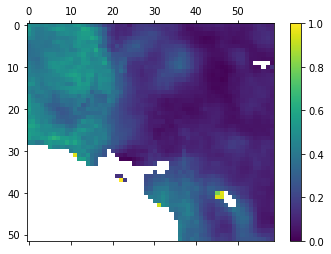

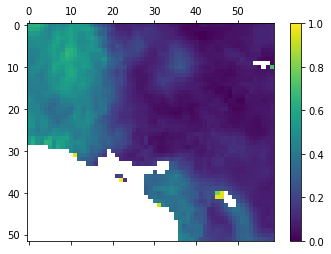

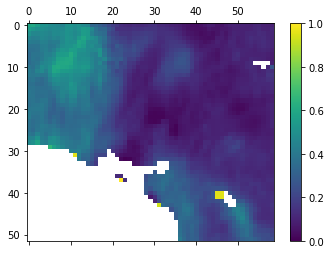

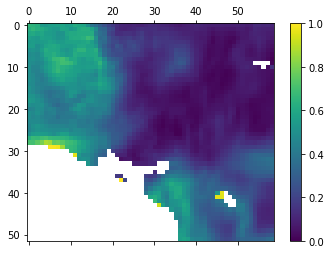

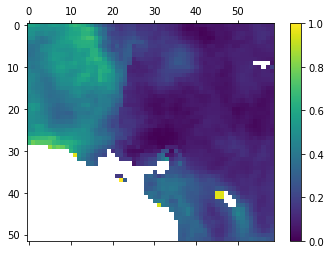

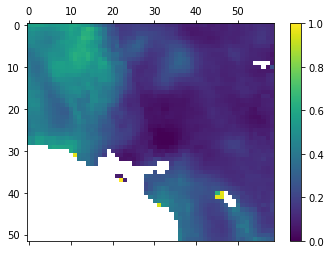

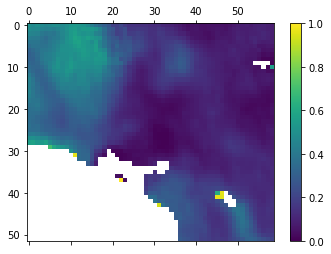

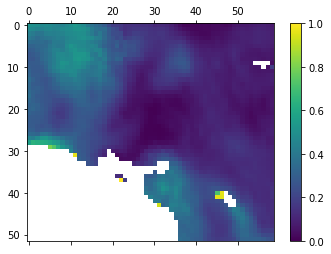

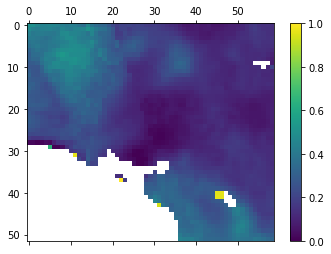

In [10]:
reshaped = normalized.reshape(data.shape)

for i in range(10):
    fig, ax = plt.subplots()
    cm = ax.matshow(normalized.reshape(data.shape)[..., i * 10])
    fig.colorbar(cm, ax=ax)
    plt.show()

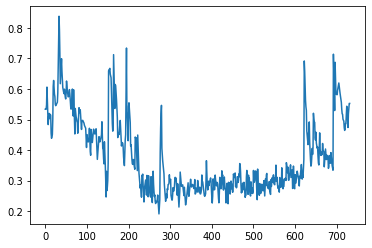

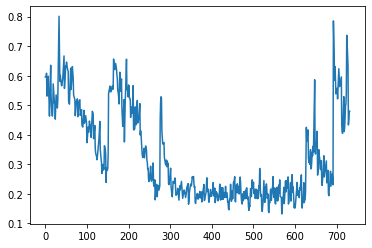

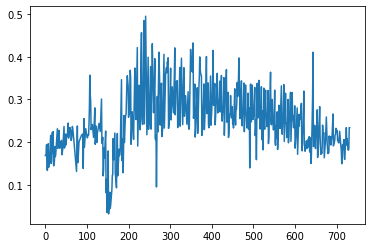

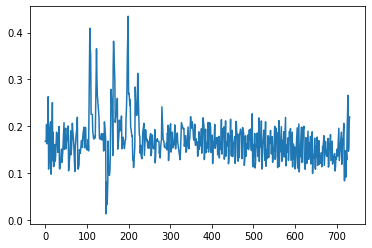

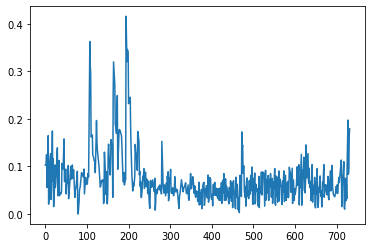

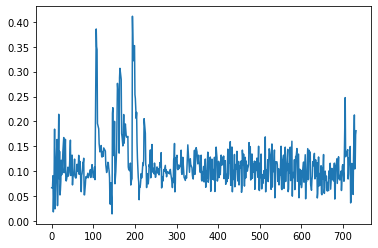

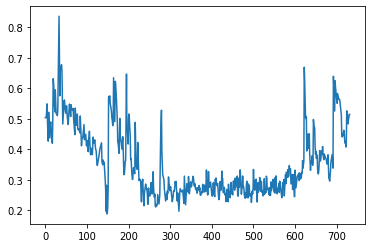

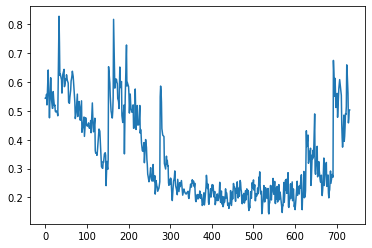

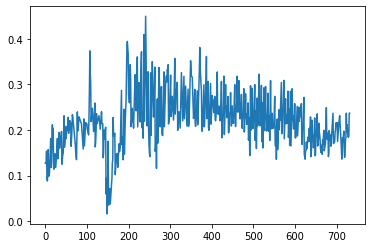

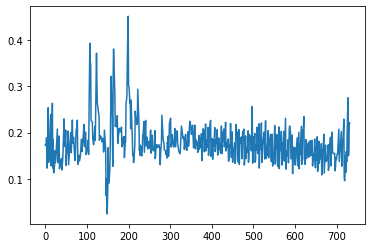

In [11]:
for i in range(10):
    plt.plot(normalized[i * 10])
    plt.show()

Create a mask for pixels observed/not which will allow us to recover spatial arrangement after masking to get rid of unobserved pixels

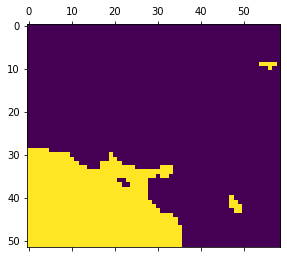

In [12]:
not_seen = np.all(np.isnan(normalized), axis=1)
model_inputs = normalized[~not_seen]

plt.matshow(not_seen.reshape(data.shape[:2]))
plt.show()

# Uncertainty-aware graph-based classification

## Prep-work

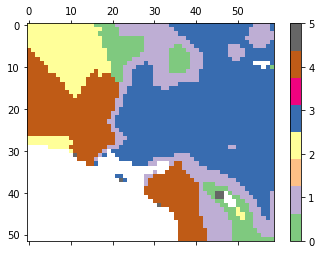

In [13]:
fig, ax = plt.subplots()
cm = ax.matshow(label_map, cmap=plt.cm.Accent)
fig.colorbar(cm, ax=ax)
plt.show()

Use `not_seen` mask to get labels in shape (#nodes,)

In [14]:
print("Labels shape: {}".format(label_map.shape))

labels = label_map.flatten()[~not_seen]
print("Labels (masked) shape: {}".format(labels.shape))

Labels shape: (52, 59)
Labels (masked) shape: (2408,)


One-hot encode labels

In [15]:
from sklearn.preprocessing import OneHotEncoder

labels_oh = OneHotEncoder().fit_transform(labels.reshape(-1, 1)).toarray()

In [16]:
print("labels_oh.shape: {}".format(labels_oh.shape))
print("first 5 labels:{}".format(labels[:5]))
print("first 5 rows:\n{}".format(labels_oh[:5]))

labels_oh.shape: (2408, 6)
first 5 labels:[2. 2. 2. 2. 2.]
first 5 rows:
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


The inputs and labels should now be of appropriate shapes

In [17]:
print(model_inputs.shape)
print(labels_oh.shape)

(2408, 732)
(2408, 6)


#### Perform dataset split

Write a function which will randomly assign each node into one of:

- training
- validation
- testing

based on a predefined ratio.

We will also pass a random seed in order to make the split reproduceable.

In [18]:
def make_splits(numb_nodes, seed, train_ratio, val_ratio):
    np.random.seed(seed)
    idxs = np.random.choice(np.arange(numb_nodes), numb_nodes, replace=False)

    splits = np.array(["empty"] * numb_nodes)
    splits[idxs[:int(numb_nodes * train_ratio)]] = "train"
    splits[idxs[int(numb_nodes * train_ratio): int(numb_nodes * (train_ratio + val_ratio))]] = "val"
    splits[idxs[int(numb_nodes * (train_ratio + val_ratio)):]] = "test"

    return splits

In [19]:
print(make_splits(20, 0, .7, .15))

['test' 'train' 'train' 'val' 'train' 'train' 'train' 'train' 'train'
 'train' 'train' 'val' 'test' 'train' 'train' 'test' 'val' 'train' 'train'
 'train']


### __Useful functions__

**Compute vacuity uncertainty**

Write a function which computes vacuity uncertainty from Dirichlet parameters.

Assume input is of shape (N, K), i.e. #nodes x #classes.

Output should be of shape (N,)

In [20]:
def get_vacuity(alphas):
    return alphas.shape[1] / np.sum(alphas, axis=1)

In [21]:
get_vacuity(np.array([[1,2,3],[1,1,1]]))

array([0.5, 1. ])

**Get belief mass vector from alpha vectors**

In [22]:
def get_belief(alphas):
    return (alphas - 1) / np.sum(alphas, axis=1, keepdims=True)

In [23]:
get_belief(np.array([[1,2,3],[1,1,1]]))

array([[0.        , 0.16666667, 0.33333333],
       [0.        , 0.        , 0.        ]])

**Compute dissonance uncertainty**

Write a function which computes dissonance uncertainty from Dirichlet parameters.

Assume input is of shape (N, K), i.e. #nodes x #classes.

Output should be of shape (N,)

In [24]:
def dissonance_uncertainty(alphas):
    alphas = np.array(alphas)  # will be used later when output might be a tf.Tensor
    belief = get_belief(alphas)
    dis_un = np.zeros(alphas.shape[0])

    for i in range(alphas.shape[0]):  # for each node
        b = belief[i]  # belief vector
        numerator, denominator = np.abs(b[:, None] - b[None, :]), b[None, :] + b[:, None]
        bal = 1 - np.true_divide(numerator, denominator, where=denominator != 0,
                                 out=np.zeros_like(denominator)) - np.eye(len(b))
        coefficients = b[:, None] * b[None, :] - np.diag(b ** 2)
        denominator = np.sum(
            b[None, :] * np.ones(belief.shape[1]) - np.diag(b), axis=-1, keepdims=True)
        dis_un[i] = (coefficients * np.true_divide(bal, denominator, where=denominator != 0,
                                                   out=np.zeros_like(bal))).sum()

    return dis_un

In [25]:
dissonance_uncertainty(np.array([[20,20,20],[3,2,10]]))

array([0.95     , 0.2569697])

**Get expected value of Dirichlet distribution from alpha vectors**

In [26]:
def expected_probability(alphas):
    return alphas / alphas.sum(axis=1, keepdims=True)

In [27]:
expected_probability(np.array([[20, 20, 20],[1, 1, 1], [3, 2, 10]]))

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.2       , 0.13333333, 0.66666667]])

**Write a function to compute the connections between pixels/nodes using k nearest neighbors**

In [28]:
def get_adj(x, k):
    a = kneighbors_graph(x, k, include_self=False)
    a = a + a.T  # to make graph symmetric (using k neighbours in "either" rather than "mutual" mode)
    a[a > 1] = 1  # get rid of any edges we just made double
    return a

### Prepare data for learning

We will use a package called `spektral` (information found [here](https://graphneural.network/)) which will do much of the heavy lifting for the graph-based deep learning.

To use this library, we will first prepare our data into a `spektral` `Dataset` object in order to be able to make use of the library's functionality.

In [29]:
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import OneHotEncoder
from spektral.data import Dataset, Graph
from spektral.datasets.utils import DATASET_FOLDER


class CustomDataset(Dataset):
    never_seen = None

    def __init__(self,
                 soil_moisture_data,
                 labels,
                 numb_neighbors,
                 seed,
                 region,
                 splits,
                 **kwargs):
        self.x = soil_moisture_data  # inputs
        self.y = labels  # ground truth (one-hot encoded)
        self.numb_neighbs = numb_neighbors  # number of neighbors (for kNN) used to compute graph
        self.mask_tr, self.mask_va, self.mask_te = None, None, None  # dataset splits
        self.numb_op_classes = labels.shape[1]  # number of output classes (labels is one-hot encoded)
        self.seed = seed  # random seed (can be used to compute average performance across different splits)
        self.splits = splits  # train/validation/test splits
        self.region = region  # used for folder naming purposes only
        super().__init__(**kwargs)

    @property
    def path(self):
        # defines a folder in which dataset is saved
        train_ratio = np.sum(self.splits == "train") / np.prod(self.splits.shape)
        val_ratio = np.sum(self.splits == "val") / np.prod(self.splits.shape)
        return os.path.join("spektral",
                            self.__class__.__name__
                            ) + "{}_classes{}_seed{}_train{:.3g}_val{:.3g}_neighbs_{}".format(self.region,
                                                                                      self.numb_op_classes,
                                                                                      self.seed,
                                                                                      train_ratio,
                                                                                      val_ratio,
                                                                                      self.numb_neighbs)

    def download(self):
        x = self.x
        y = self.y
        splits = self.splits

        # get graph adjacency
        a = get_adj(x, k=self.numb_neighbs)  # k is the number of nearest neighbours to look for

        # Create the directory
        if not os.path.isdir("spektral"):
            os.mkdir("spektral")
        os.mkdir(self.path)

        filename = os.path.join(self.path, 'graph')
        
        np.savez(filename, x=x, a=a, y=y)

    def read(self):
        data = np.load(os.path.join(self.path, f'graph.npz'), allow_pickle=True)

        x = data['x'].astype(np.float32)
        a = data['a'].tolist()
        y = data['y'].astype(np.uint8)

        self.mask_tr = (self.splits == "train")
        self.mask_va = (self.splits == "val")
        self.mask_te = (self.splits == "test")

        return [Graph(x=x, a=a, y=y)]

In [30]:
from spektral.transforms import LayerPreprocess, AdjToSpTensor
from spektral.layers import GCNConv
from spektral.models import GCN

random_seed = 0
sm = CustomDataset(model_inputs,
                   labels_oh,
                   5,
                   random_seed,
                   region,
                   make_splits(labels_oh.shape[0], random_seed, train_ratio=.1, val_ratio=.05),
                   transforms=[LayerPreprocess(GCNConv)]
                  )

### Perform learning

Create model

In [31]:
import tensorflow as tf

tf.random.set_seed(random_seed)
model = GCN(n_labels=labels_oh.shape[1], channels=32, output_activation=lambda z: tf.exp(z) + 1, l2_reg=0.001)

2023-02-08 10:33:56.415160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 10:33:56.441010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 10:33:56.441192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 10:33:56.442423: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Write loss function and compile network

In [32]:
class SquareErrorDirichlet(tf.keras.losses.Loss):
    def __init__(self, name="square_error_dirichlet"):
        super().__init__(name=name)

    def call(self, y_true, alpha):
        y_true = tf.cast(y_true, tf.float32)
        strength = tf.reduce_sum(alpha, axis=1, keepdims=True)
        prob = tf.divide(alpha, strength)
        loss = tf.square(prob - y_true) + prob * (1 - prob) / (strength + 1.0)
        return tf.reduce_sum(loss, axis=-1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=SquareErrorDirichlet(),
    weighted_metrics=["acc"]
)

Perform training

In [33]:
def weight_by_class(y, weights):
    samples = y[weights != 0].sum(axis=0)  # count how many
    samples = np.true_divide(len(weights), samples * len(samples[samples != 0]), out=0. * samples, where=samples != 0)
    return (y * samples).max(axis=-1) * weights

In [34]:
from spektral.data import SingleLoader

weights_tr, weights_va = [weight_by_class(sm[0].y, mask) for mask in [sm.mask_tr, sm.mask_va]]
loader = SingleLoader(sm, sample_weights=weights_tr)
steps_per_epoch = loader.steps_per_epoch
loader_tr = loader.load()
loader_va = SingleLoader(sm, sample_weights=weights_va).load()


history = model.fit(
    loader_tr,
    steps_per_epoch=steps_per_epoch,
    validation_data=loader_va,
    validation_steps=steps_per_epoch,
    epochs=2000,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50,
                                                restore_best_weights=True),
               tf.keras.callbacks.ModelCheckpoint(os.path.join("GCN.h5"),
                                                  monitor="val_loss", save_best_only=True,
                                                  save_weights_only=True)]
)


Epoch 1/2000


2023-02-08 10:33:59.381569: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 3s 3s/step - loss: 0.9685 - acc: 0.0891 - val_loss: 1.0190 - val_acc: 0.1667
Epoch 2/2000
1/1 [==============================] - 0s 27ms/step - loss: 0.9242 - acc: 0.1984 - val_loss: 0.9996 - val_acc: 0.1667
Epoch 3/2000
1/1 [==============================] - 0s 25ms/step - loss: 0.8846 - acc: 0.1920 - val_loss: 0.9769 - val_acc: 0.1667
Epoch 4/2000
1/1 [==============================] - 0s 27ms/step - loss: 0.8895 - acc: 0.2447 - val_loss: 0.9726 - val_acc: 0.1716
Epoch 5/2000
1/1 [==============================] - 0s 23ms/step - loss: 0.8552 - acc: 0.2570 - val_loss: 0.9261 - val_acc: 0.2843
Epoch 6/2000
1/1 [==============================] - 0s 23ms/step - loss: 0.7826 - acc: 0.3768 - val_loss: 0.9192 - val_acc: 0.2941
Epoch 7/2000
1/1 [==============================] - 0s 23ms/step - loss: 0.8222 - acc: 0.2989 - val_loss: 0.9121 - val_acc: 0.2990
Epoch 8/2000
1/1 [==============================] - 0s 24ms/step - loss: 0.7959 - acc: 0.3590 - va

Epoch 125/2000
1/1 [==============================] - 0s 21ms/step - loss: 0.2790 - acc: 0.8740 - val_loss: 0.5882 - val_acc: 0.6508
Epoch 126/2000
1/1 [==============================] - 0s 31ms/step - loss: 0.2989 - acc: 0.8604 - val_loss: 0.5761 - val_acc: 0.6441
Epoch 127/2000
1/1 [==============================] - 0s 25ms/step - loss: 0.2885 - acc: 0.8458 - val_loss: 0.5734 - val_acc: 0.6610
Epoch 128/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.2729 - acc: 0.8597 - val_loss: 0.6023 - val_acc: 0.6659
Epoch 129/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.2741 - acc: 0.8749 - val_loss: 0.6477 - val_acc: 0.6420
Epoch 130/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.2735 - acc: 0.8474 - val_loss: 0.6361 - val_acc: 0.6659
Epoch 131/2000
1/1 [==============================] - 0s 17ms/step - loss: 0.2735 - acc: 0.8546 - val_loss: 0.6156 - val_acc: 0.6659
Epoch 132/2000
1/1 [==============================] - 0s 18ms/step - 

Epoch 248/2000
1/1 [==============================] - 0s 18ms/step - loss: 0.2309 - acc: 0.8956 - val_loss: 0.6209 - val_acc: 0.6804
Epoch 249/2000
1/1 [==============================] - 0s 17ms/step - loss: 0.2418 - acc: 0.8889 - val_loss: 0.6271 - val_acc: 0.6840
Epoch 250/2000
1/1 [==============================] - 0s 17ms/step - loss: 0.2578 - acc: 0.8557 - val_loss: 0.5887 - val_acc: 0.6585
Epoch 251/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.2719 - acc: 0.8287 - val_loss: 0.6206 - val_acc: 0.6500
Epoch 252/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.2830 - acc: 0.8508 - val_loss: 0.5658 - val_acc: 0.6853
Epoch 253/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.2347 - acc: 0.8785 - val_loss: 0.5877 - val_acc: 0.6688
Epoch 254/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.2496 - acc: 0.8563 - val_loss: 0.6086 - val_acc: 0.6804
Epoch 255/2000
1/1 [==============================] - 0s 16ms/step - 

Epoch 371/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.2385 - acc: 0.8599 - val_loss: 0.5835 - val_acc: 0.6920
Epoch 372/2000
1/1 [==============================] - 0s 17ms/step - loss: 0.2149 - acc: 0.9204 - val_loss: 0.5452 - val_acc: 0.6787
Epoch 373/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.2069 - acc: 0.9098 - val_loss: 0.5448 - val_acc: 0.6808
Epoch 374/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.2097 - acc: 0.9221 - val_loss: 0.5319 - val_acc: 0.6825
Epoch 375/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.2299 - acc: 0.9146 - val_loss: 0.5744 - val_acc: 0.6653
Epoch 376/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.2313 - acc: 0.8896 - val_loss: 0.5828 - val_acc: 0.6766
Epoch 377/2000
1/1 [==============================] - 0s 17ms/step - loss: 0.2364 - acc: 0.8832 - val_loss: 0.5354 - val_acc: 0.7039
Epoch 378/2000
1/1 [==============================] - 0s 17ms/step - 

In [35]:
loader_all = SingleLoader(sm, epochs=1)
inputs, outputs = loader_all.__next__()
alpha = np.array(model(inputs, training=True))

In [36]:
def imageify(values, shape, never_seen):
    if values.ndim == 1:
        image = np.zeros(shape) * np.nan
    else:
        image = np.zeros(shape + values.shape[1:]) * np.nan
    image[~never_seen.reshape(shape)] = values
    return image

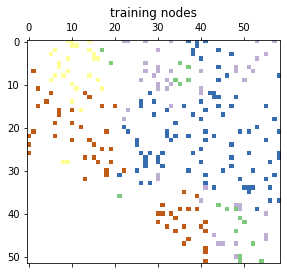

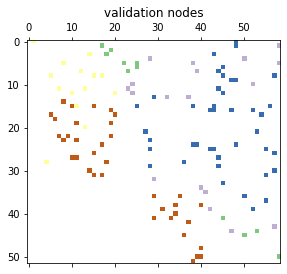

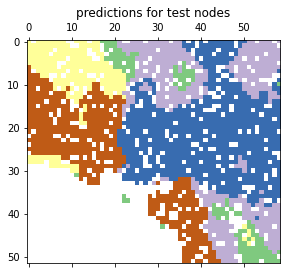

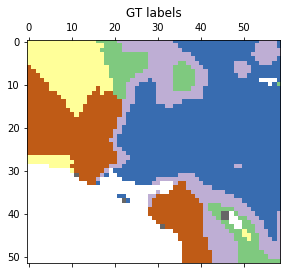

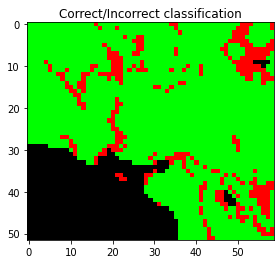

In [37]:
predicted_labels_tr = imageify(alpha.argmax(axis=1), data.shape[:2], not_seen)
predicted_labels_tr[imageify(sm.mask_tr, data.shape[:2], not_seen) != True] = np.nan
plt.matshow(predicted_labels_tr, cmap=plt.cm.Accent, vmin=0, vmax=alpha.shape[1] - 1)
plt.title("training nodes")
plt.show()

predicted_labels_va = imageify(alpha.argmax(axis=1), data.shape[:2], not_seen)
predicted_labels_va[imageify(sm.mask_va, data.shape[:2], not_seen) != True] = np.nan
plt.matshow(predicted_labels_va, cmap=plt.cm.Accent, vmin=0, vmax=alpha.shape[1] - 1)
plt.title("validation nodes")
plt.show()

predicted_labels_te = imageify(alpha.argmax(axis=1), data.shape[:2], not_seen)
predicted_labels_te[imageify(sm.mask_te, data.shape[:2], not_seen) != True] = np.nan
plt.matshow(predicted_labels_te, cmap=plt.cm.Accent, vmin=0, vmax=alpha.shape[1] - 1)
plt.title("predictions for test nodes")
plt.show()

plt.matshow(imageify(sm[0].y.argmax(axis=1), data.shape[:2], not_seen), cmap=plt.cm.Accent, vmin=0, vmax=alpha.shape[1] - 1)
plt.title("GT labels")
plt.show()

right_vs_wrong = np.ones(alpha.shape[0:1] + (3,))
right_vs_wrong[alpha.argmax(axis=1) == sm[0].y.argmax(axis=1)] = [0, 1, 0]
right_vs_wrong[alpha.argmax(axis=1) != sm[0].y.argmax(axis=1)] = [1, 0, 0]
plt.imshow(imageify(right_vs_wrong, data.shape[:2], not_seen))
plt.title("Correct/Incorrect classification")
plt.show()

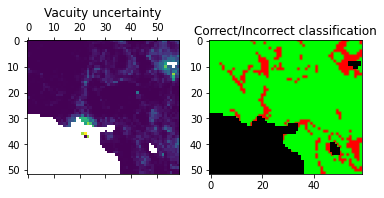

In [38]:
fig, ax = plt.subplots(1, 2)
cm = ax[0].matshow(imageify(get_vacuity(alpha), data.shape[:2], not_seen))
# fig.colorbar(cm, ax=ax[0])
ax[0].set_title("Vacuity uncertainty")
ax[1].imshow(imageify(right_vs_wrong, data.shape[:2], not_seen))
ax[1].set_title("Correct/Incorrect classification")
plt.show()

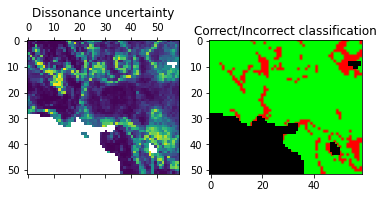

In [39]:
fig, ax = plt.subplots(1, 2)
cm = ax[0].matshow(imageify(dissonance_uncertainty(alpha), data.shape[:2], not_seen))
# fig.colorbar(cm, ax=ax[0])
ax[0].set_title("Dissonance uncertainty")
ax[1].imshow(imageify(right_vs_wrong, data.shape[:2], not_seen))
ax[1].set_title("Correct/Incorrect classification")
plt.show()